<a href="https://colab.research.google.com/github/Gorgens/analises-espaciais/blob/main/luc_modeling_paru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('terra')
install.packages('rasterDT')
install.packages('raster')
#install.packages('tmap')
install.packages('tidyverse')
install.packages('rpart')
install.packages('rpart.plot')
install.packages('fastDummies')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘sp’, ‘wk’, ‘RcppArmadillo’, ‘classInt’, ‘s2’, ‘units’, ‘raster’, ‘fasterize’, ‘sf’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘gridExtra’, ‘geometries’, ‘jsonify’, ‘rapidjsonr’, ‘sfheaders’, ‘lwgeom’, ‘dichromat’, ‘XML’, ‘crosstalk’, ‘leaflet.providers’, ‘png’, ‘viridis’, ‘geojsonsf’, ‘tmaptools’, ‘stars’, ‘htmlwidgets’, ‘widgetframe’, ‘leaflet’, ‘leafsync’, ‘leafem’, ‘abind’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘

In [ ]:
# Pacotes para manipulação espacial
require(terra)
require(rasterDT)
require(raster)
#require(tmap)
require(tidyverse)

Loading required package: terra

terra 1.7.65

Loading required package: rasterDT

Loading required package: raster

Loading required package: sp

Loading required package: data.table


Attaching package: ‘data.table’


The following object is masked from ‘package:raster’:

    shift


The following object is masked from ‘package:terra’:

    shift


Loading required package: tmap

Breaking News: tmap 3.x is retiring. Please test v4, e.g. with
remotes::install_github('r-tmap/tmap')

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ tidyr::extract()     masks raster::extract(), terra::extract()
✖ dplyr::filte

In [ ]:
# Pacotes para modelagem
require(rpart)
require(rpart.plot)
require(fastDummies)

Loading required package: rpart

Loading required package: rpart.plot

Loading required package: fastDummies

Thank you for using fastDummies!

To acknowledge our work, please cite the package:

Kaplan, J. & Schlegel, B. (2023). fastDummies: Fast Creation of Dummy (Binary) Columns and Rows from Categorical Variables. Version 1.7.1. URL: https://github.com/jacobkap/fastDummies, https://jacobkap.github.io/fastDummies/.



# Abrir bases espaciais

In [ ]:
uso10reclass <- raster('rasters_paru/uso10reclass.tif')
uso15reclass <- raster('rasters_paru/uso15reclass.tif')

uso17reclass <- raster('rasters_paru/uso17reclass.tif')
uso22reclass <- raster('rasters_paru/uso22reclass.tif')

terrain <- raster('rasters_paru/terrainResample.tif')
dirMinerario <- raster('rasters_paru/dirMinerarioResample.tif')
drenagem <- raster('rasters_paru/drenagemResample.tif')
focos <- raster( "rasters_paru/focosResample.tif")

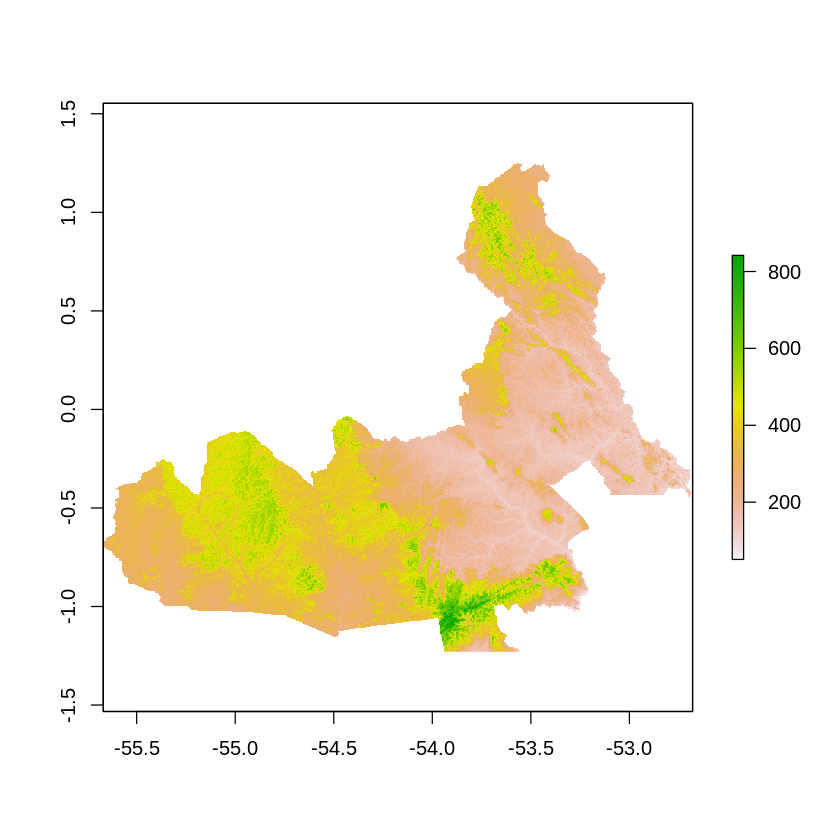

In [ ]:
plot(terrain)

In [ ]:
lu <- stack(uso10reclass, uso15reclass, uso17reclass, uso22reclass, dirMinerario, drenagem, focos)
names(lu) <- c("uso10", "uso15", "uso17", "uso22", "mineracao", "hdrenagem", "focos")

# Markov transição

In [ ]:
transProFloresta <- crosstabDT(lu$uso15, lu$uso10)
print(transProFloresta)

    y
x           1    14   30    33
  1  14418417  8342    5  3248
  14     6650 11910    0     0
  30      186     8 1182    16
  33      733     0   15 30437


In [ ]:
transProLUC <- crosstabDT(lu$uso22, lu$uso17)
print(transProLUC)

    y
x           1    14   30    33
  1  14400502  4754    3  4741
  14    20621 16580    0     3
  30      376     1 1432    39
  33     6046     0    0 26051


In [ ]:
chisq.test(transProFloresta, transProLUC, simulate.p.value = TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  transProFloresta
X-squared = 30306703, df = NA, p-value = 0.0004998


# Modelando transição usando ML

In [ ]:
lu.df <- na.omit(as.data.frame(lu))
lu.df <- lu.df %>% dummy_cols(select_columns = 'uso15')
#head(lu.df)

# Mapas de risco

## Mapa de risco para mineração ilegal

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


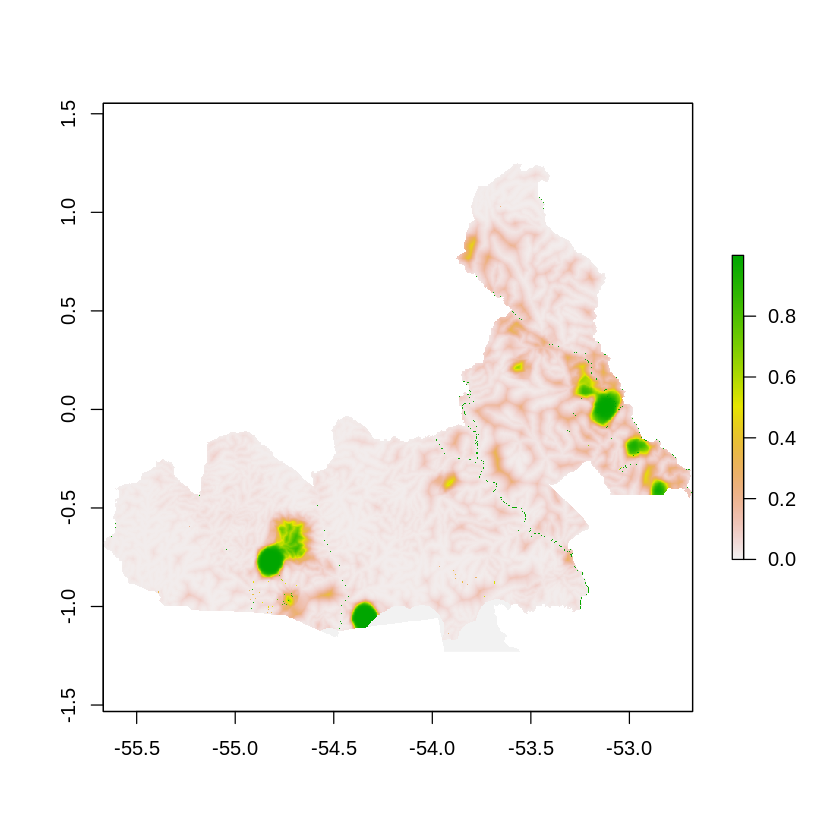

In [ ]:
luc_sample <- slice_sample(lu.df, n = 500, by = uso15_30)
glm_mineracao <- glm(formula = uso15_30 ~ uso10 + mineracao + hdrenagem + focos, family = binomial(link = "logit"), data = luc_sample)

temp = lu[[c(4,5,6,7)]]
names(temp) = c('uso10', 'mineracao', 'hdrenagem', 'focos')

#probMineracao <- predict(lu[[c(4,5,6,7)]], glm_mineracao)
probMineracao <- predict(temp, glm_mineracao)
probMineracao <- 1 / (1 + exp(-probMineracao))
plot(probMineracao)

## Mapa de risco para desmatamento e grilagem

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


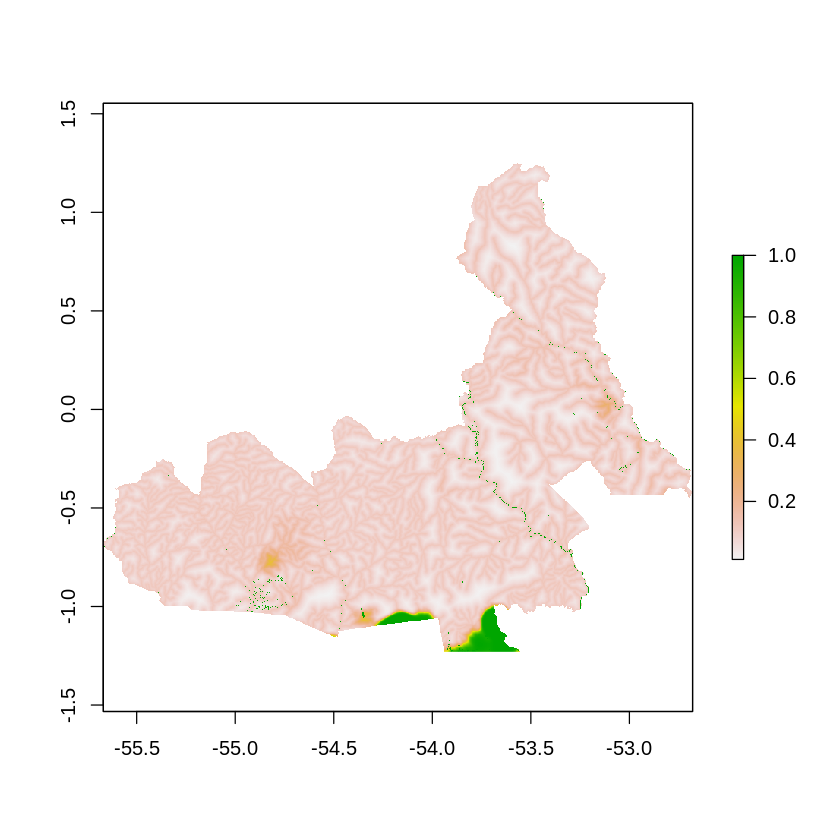

In [ ]:
luc_sample <- slice_sample(lu.df, n = 500, by = uso15_14)
glm_agro <- glm(formula = uso15_14 ~ uso10 + mineracao + hdrenagem + focos, family = binomial(link = "logit"), data = luc_sample)

probAgro <- predict(lu[[c(1,5,6,7)]], glm_agro)
probAgro <- 1 / (1 + exp(-probAgro))
plot(probAgro)